In [1]:
# Cell 1
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob

%matplotlib inline

## Step 1. EDA
___
Display of pictures for analysis

(720, 1280, 3)


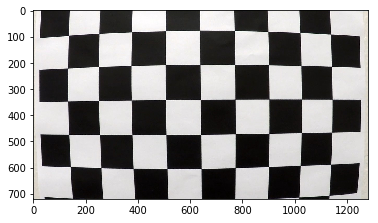

In [2]:
# Cell 2
img = mpimg.imread('camera_cal/calibration1.jpg')
image_shape = img.shape
print(image_shape)
plt.imshow(img)

## Step 2: Calibration
______
1. Obtain camera matrix, distortion coefficiencts. 
2. Ran over all calibration images

In [3]:
# Cell 3
nx = 9
ny = 6

objpoints = []
imgpoints = []

objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

calibration_images = glob.glob("camera_cal/calibration*.jpg")

for images in calibration_images:
    img = mpimg.imread(images)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    if ret:
        objpoints.append(objp)
        imgpoints.append(corners)
        
# use the object and image points to caliberate the camera and compute the camera matrix and distortion coefficients
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image_shape[:2], None, None)

## Step 3: Distortion Correction
__________
Undistort the calibration image for testing using undistort

In [4]:
# Cell 4
def undistort(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

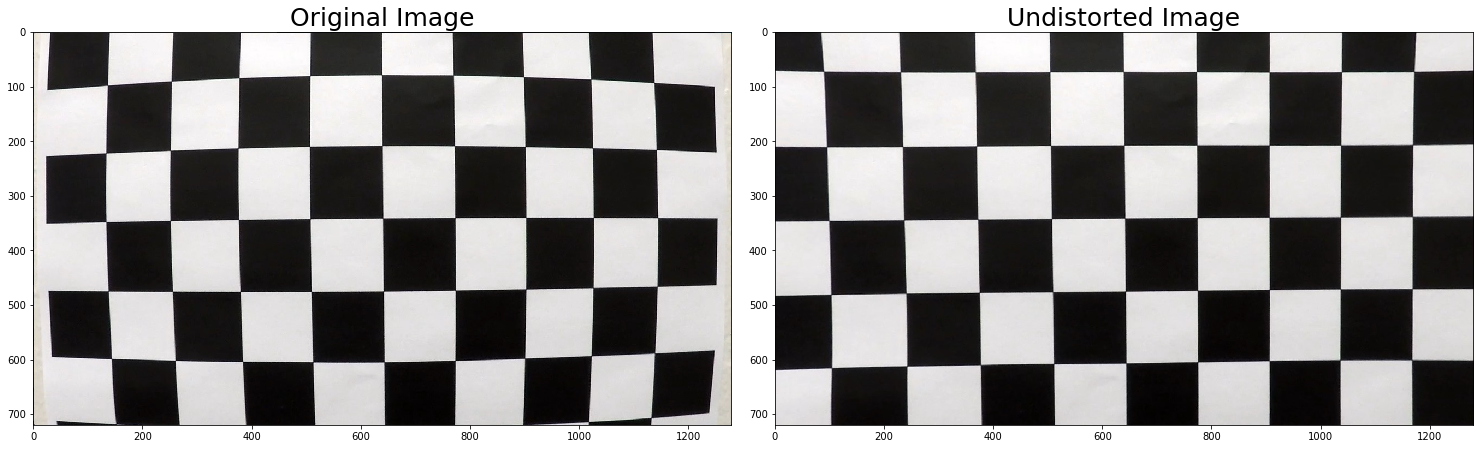

In [5]:
# Cell 5
img = mpimg.imread('camera_cal/calibration1.jpg')
undistorted = undistort(img, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 12))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

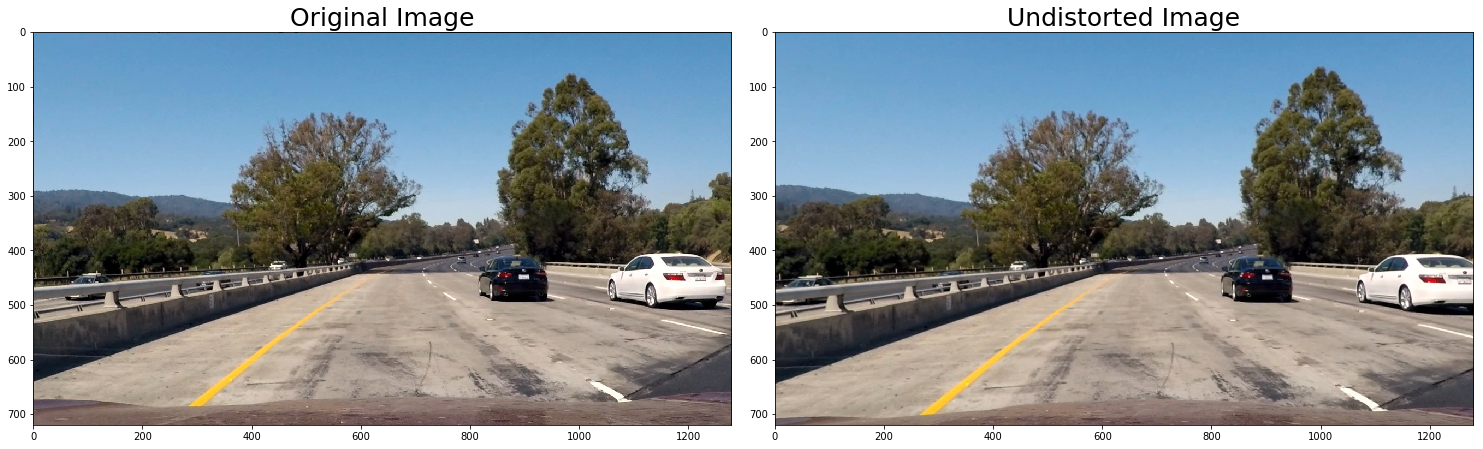

In [6]:
# Cell 6
img = mpimg.imread('test_images/test1.jpg')
undistorted = undistort(img, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 12))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Step 4: Sobel, Threshold and Color Transform
________________

#### Performing general image processing functions::
1. Undistortion
2. Grayscale
3. Gradient Threshold
4. Directional Threshold
5. Combination
6. Region of Interest

In [7]:
# Cell 7
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)   
    
def enhance_img(img):
    dst = cv2.GaussianBlur(img, (0,0), 3)
    out = cv2.addWeighted(img, 1.5, dst, -0.5, 0)
    return out

def abs_sobel_thresh(gray, orient='x', thresh_min=0, thresh_max=255):
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    abs_sobel = np.absolute(sobel)
    max_value = np.max(abs_sobel)
    scaled_sobel = np.uint8(255*abs_sobel/max_value)
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return binary_output


def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    absgraddir = np.absolute(absgraddir)
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output


# Taken from P1 Project
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    # defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    # defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    # filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, [vertices], ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def thresholded_image(img):    
    img = undistort(img, mtx, dist)
    
    # convert to gray scale
    gray = grayscale(img) 
    gray = enhance_img(gray)
    height, width = gray.shape
    
    # apply gradient threshold on the horizontal gradient
    sx_binary = abs_sobel_thresh(gray, 'x', 40, 200)
    
    # apply gradient direction threshold so that only edges closer to vertical are detected.
    dir_binary = dir_threshold(gray, thresh=(np.pi/6, np.pi/2))
    
    # combine the gradient and direction thresholds.
    combined_condition = ((sx_binary == 1) & (dir_binary == 1))
    
    # R & G thresholds so that yellow lanes are detected well.
    color_threshold = 150
    r_channel = img[:,:,0]
    g_channel = img[:,:,1]
    color_combined = np.zeros_like(r_channel)
    r_g_channel_condition = (r_channel > color_threshold) & (g_channel > color_threshold)
    
    # color channel thresholds
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    l_channel = hls[:,:,1]
    
    # S channel performs well for detecting bright yellow and white lanes
    s_thresh = (100, 255)
    s_condition = (s_channel > s_thresh[0]) & (s_channel <= s_thresh[1])
    
    # We put a threshold on the L channel to avoid pixels which have shadows and as a result darker.
    l_thresh = (120, 255)
    l_condition = (l_channel > l_thresh[0]) & (l_channel <= l_thresh[1])

    # combine all the thresholds
    # A pixel should either be a yellowish or whiteish
    # And it should also have a gradient, as per our thresholds
    color_combined[(r_g_channel_condition & l_condition) & (s_condition | combined_condition)] = 1
    
    vertices = np.array([[0, height-1], [width/1.75, height/1.75], [width-1/2, height-1/2]], dtype=np.int32)
    masked_image = region_of_interest(color_combined, vertices)
    
    return masked_image

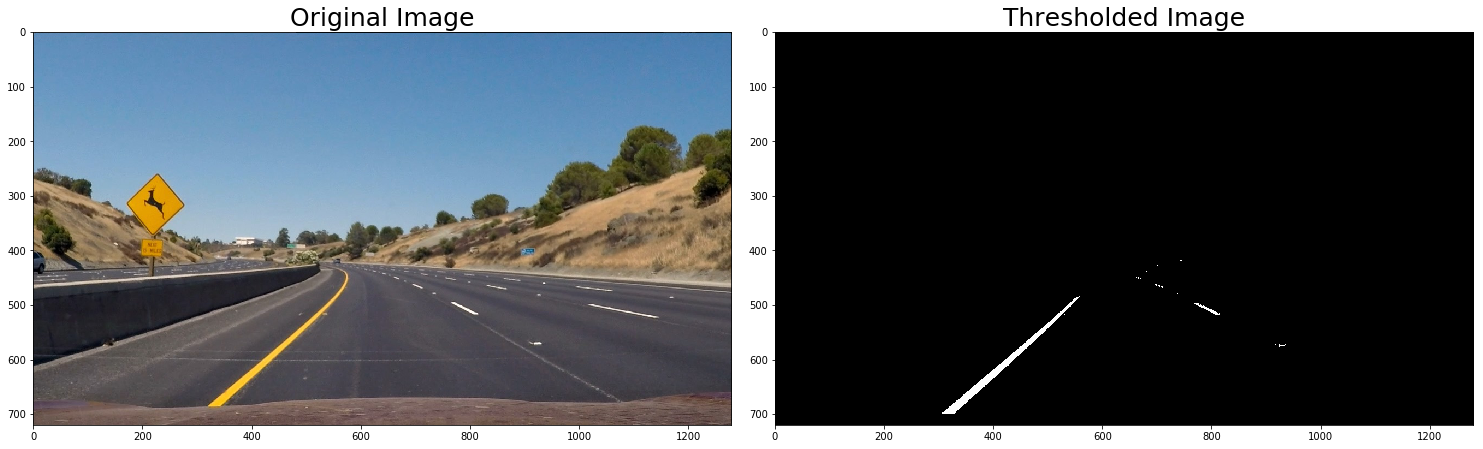

In [8]:
# Cell 8
img = mpimg.imread('test_images/test2.jpg')
thresholded = thresholded_image(img)
cv2.imwrite('thresholded.jpg',thresholded)

# Plot the 2 images side by side
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 12))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(thresholded, cmap='gray')
ax2.set_title('Thresholded Image', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Step 5: Perspective Transform
_______________


1. Function performs perspective transform
2. Raw co-ordinates entered manually for the transformation

In [9]:
# Cell 9
def perspective_transform(thresholded, bottom_left_src, bottom_right_src, top_left_src, top_right_src, bottom_left_dst, bottom_right_dst, top_left_dst, top_right_dst, img_size, flag=False):
    
    source = np.float32([bottom_left_src, bottom_right_src, top_left_src, top_right_src])
    pts = np.array([bottom_left_src, bottom_right_src, top_left_src, top_right_src], np.int32)
    pts = pts.reshape((-1,1,2))
    copy = img.copy()
    cv2.polylines(copy,[pts],True,(255,0,0), thickness=3)

    dst = np.float32([bottom_left_dst, bottom_right_dst, top_left_dst, top_right_dst])
    M = cv2.getPerspectiveTransform(source, dst)
    M_inv = cv2.getPerspectiveTransform(dst, source)
    img_size = (image_shape[1], image_shape[0])
    
    if flag == False:
        warped = cv2.warpPerspective(thresholded, M, img_size , flags=cv2.INTER_LINEAR)
    if flag == True:
        warped = cv2.warpPerspective(thresholded, M_inv, img_size , flags=cv2.INTER_LINEAR)
    
    return warped, M, M_inv
    

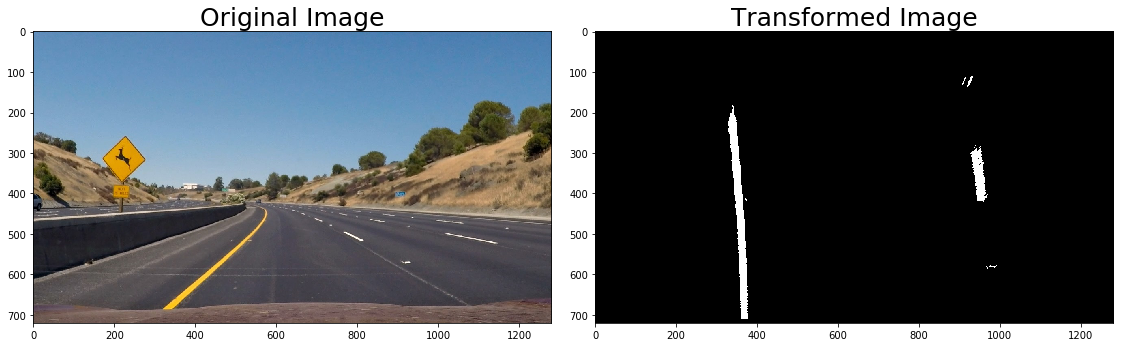

In [10]:
# Cell 10
bottom_left_src = [220,720]
bottom_right_src = [1110, 720]
top_left_src = [570, 470]
top_right_src = [722, 470]

bottom_left_dst = [320,720]
bottom_right_dst = [920, 720]
top_left_dst = [320, 1]
top_right_dst = [920, 1]
    
#bottom_left_src = [585,460]
#bottom_right_src = [203.33, 720]
#top_left_src = [1126, 720]
#top_right_src = [695, 460]

#bottom_left_dst = [320,0]
#bottom_right_dst = [320, 720]
#top_left_dst = [960, 720]
#top_right_dst = [960, 0]
img_size = (image_shape[1], image_shape[0])

warped, M, M_inv = perspective_transform(thresholded, bottom_left_src, bottom_right_src, top_left_src, top_right_src,
                                             bottom_left_dst, bottom_right_dst, top_left_dst, top_right_dst, img_size)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(warped, cmap='gray')
ax2.set_title('Transformed Image', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Step 6: Lane Line Pixels for Image
_____________________
### Histogram
The peaks in the histogram tell us about the likely position of the lanes in the image.

In [11]:
# Cell 11
def histogram(warped):
    histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)

    # Peak in the first half indicates the likely position of the left lane
    half_width = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:half_width])

    # Peak in the second half indicates the likely position of the right lane
    rightx_base = np.argmax(histogram[half_width:]) + half_width
    return(histogram, leftx_base, rightx_base)

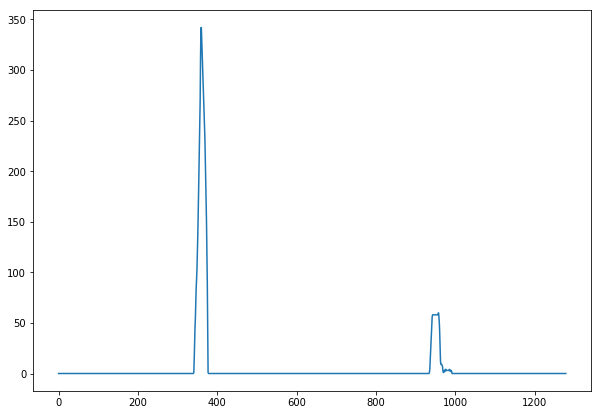

In [12]:
# Cell 12
histogram, leftx_base, rightx_base = histogram(warped)
plt.figure(figsize=(10,7))
plt.plot(histogram)

### Sliding Window Search

1. Sliding window search using the histogram peaks as reference for the 2 lanes. Used 9 windows of width 100 pixels.
2. Polynomial (rectangle) is formed and lane lines are drawn accordingly

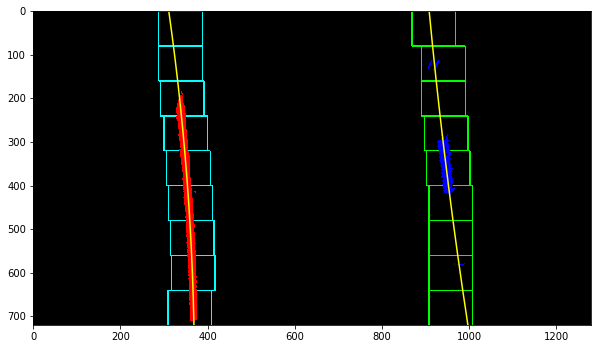

In [13]:
# Cell 13
out_img = np.dstack((warped, warped, warped))*255

nonzeros = warped.nonzero()
nonzeros_y = nonzeros[0]
nonzeros_x = nonzeros[1]

num_windows = 9
num_rows = warped.shape[0]
window_height = np.int(num_rows/num_windows)
window_half_width = 50

min_pixels = 100

left_coordinates = []
right_coordinates = []

for window in range(num_windows):
    y_max = num_rows - window*window_height
    y_min = num_rows - (window+1)* window_height
    
    leftx_min = leftx_base - window_half_width
    leftx_max = leftx_base + window_half_width
    
    cv2.rectangle(out_img, (leftx_min, y_min), (leftx_max, y_max), [0,255,255],2)
    
    left_lane_inds = ((nonzeros_x >= leftx_min) & (nonzeros_x <= leftx_max) & (nonzeros_y >= y_min) & (nonzeros_y <= y_max)).nonzero()[0]
    left_coordinates.append(left_lane_inds)
    
    if len(left_lane_inds) > min_pixels:
        leftx_base = np.int(np.mean(nonzeros_x[left_lane_inds]))
    
    rightx_min = rightx_base - window_half_width
    rightx_max = rightx_base + window_half_width
    
    cv2.rectangle(out_img, (rightx_min, y_min), (rightx_max, y_max), [0,255,0],2)
    
    right_lane_inds = ((nonzeros_x >= rightx_min) & (nonzeros_x <= rightx_max) & (nonzeros_y >= y_min) & (nonzeros_y <= y_max)).nonzero()[0]
    right_coordinates.append(right_lane_inds)
        
    if len(right_lane_inds) > min_pixels:
        rightx_base = np.int(np.mean(nonzeros_x[right_lane_inds]))
        
left_coordinates = np.concatenate(left_coordinates)
right_coordinates = np.concatenate(right_coordinates)

out_img[nonzeros_y[left_coordinates], nonzeros_x[left_coordinates]] = [255,0,0]
out_img[nonzeros_y[right_coordinates], nonzeros_x[right_coordinates]] = [0,0,255]

leftx = nonzeros_x[left_coordinates]
lefty = nonzeros_y[left_coordinates]

polyfit_left = np.polyfit(lefty, leftx, 2)

rightx = nonzeros_x[right_coordinates]
righty = nonzeros_y[right_coordinates]

polyfit_right = np.polyfit(righty, rightx, 2)

y_points = np.linspace(0, num_rows-1, num_rows)

leftx_predictions = polyfit_left[0]*y_points**2 + polyfit_left[1]*y_points + polyfit_left[2]

rightx_predictions = polyfit_right[0]*y_points**2 + polyfit_right[1]*y_points + polyfit_right[2]

plt.figure(figsize=(10,7))
plt.imshow(out_img)
plt.plot(leftx_predictions, y_points, color='yellow')
plt.plot(rightx_predictions, y_points, color='yellow')

### Sliding Window Search using prior Information

Consecutive frames have lane lines very close to each other, so we use a margin of 50 pixels within the sliding window

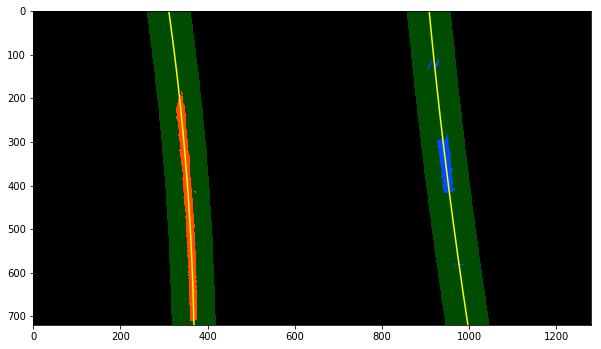

In [14]:
# Cell 14
margin = 50
out_img = np.dstack((warped, warped, warped))*255

leftx_predictions = polyfit_left[0]*nonzeros_y**2 + polyfit_left[1]*nonzeros_y + polyfit_left[2]
left_coordinates = ((nonzeros_x >= leftx_predictions - margin) & (nonzeros_x <= leftx_predictions + margin)).nonzero()[0]

rightx_predictions = polyfit_right[0]*nonzeros_y**2 + polyfit_right[1]*nonzeros_y + polyfit_right[2]
right_coordinates = ((nonzeros_x >= rightx_predictions - margin) & (nonzeros_x <= rightx_predictions + margin)).nonzero()[0]

out_img[nonzeros_y[left_coordinates], nonzeros_x[left_coordinates]] = [255,0,0]
out_img[nonzeros_y[right_coordinates], nonzeros_x[right_coordinates]] = [0,0,255]

leftx = nonzeros_x[left_coordinates]
lefty = nonzeros_y[left_coordinates]

polyfit_left = np.polyfit(lefty, leftx, 2)

rightx = nonzeros_x[right_coordinates]
right_y = nonzeros_y[right_coordinates]

polyfit_right = np.polyfit(right_y, rightx, 2)

y_points = np.linspace(0, num_rows-1, num_rows)

leftx_predictions = polyfit_left[0]*y_points**2 + polyfit_left[1]*y_points + polyfit_left[2]
rightx_predictions = polyfit_right[0]*y_points**2 + polyfit_right[1]*y_points + polyfit_right[2]

window_img = np.zeros_like(out_img)

left_line_window_1 = np.array(np.transpose(np.vstack([leftx_predictions - margin, y_points])))
left_line_window_2 = np.array(np.flipud(np.transpose(np.vstack([leftx_predictions + margin, y_points]))))
left_line_points = np.vstack((left_line_window_1, left_line_window_2))

cv2.fillPoly(window_img, np.int_([left_line_points]), [0,255, 0])

right_line_window_1 = np.array(np.transpose(np.vstack([rightx_predictions - margin, y_points])))
right_line_window_2 = np.array(np.flipud(np.transpose(np.vstack([rightx_predictions + margin, y_points]))))
right_line_points = np.vstack((right_line_window_1, right_line_window_2))

cv2.fillPoly(window_img, np.int_([left_line_points]), [0,255, 0])
cv2.fillPoly(window_img, np.int_([right_line_points]), [0,255, 0])

result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.figure(figsize=(10,7))
plt.imshow(result)
plt.plot(leftx_predictions, y_points, color='yellow')
plt.plot(rightx_predictions, y_points, color='yellow')

## Step 7: Radius of Curvature and Offset
___________________________
Finding the curvature of the road and the position of the car from the center


In [15]:
# Cell 15
def radius_of_curvature(x_values):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # If no pixels were found return None
    y_points = np.linspace(0, num_rows-1, num_rows)
    y_eval = np.max(y_points)

    # Fit new polynomials to x,y in world space
    fit_cr = np.polyfit(y_points*ym_per_pix, x_values*xm_per_pix, 2)
    curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    return curverad

left_curve_rad = radius_of_curvature(leftx_predictions)
right_curve_rad = radius_of_curvature(rightx_predictions)
average_curve_rad = (left_curve_rad + right_curve_rad)/2
curvature_string = "Radius of Curvature of Lane Found: %.2f m" % average_curve_rad
print(curvature_string)

# compute the offset from the center
lane_center = (rightx_predictions[719] + leftx_predictions[719])/2
xm_per_pix = 3.7/700 # meters per pixel in x dimension
center_offset_pixels = abs(img_size[0]/2 - lane_center)
center_offset_mtrs = xm_per_pix*center_offset_pixels
offset_string = "Position of Car from Centre: %.2f m" % center_offset_mtrs
print(offset_string)

Radius of Curvature of Lane Found: 3024.89 m
Position of Car from Centre: 0.23 m


## Step 8: Inverse Transformation
_______________________

Converting the warped image to normal and combine with original image to form the lane over the image

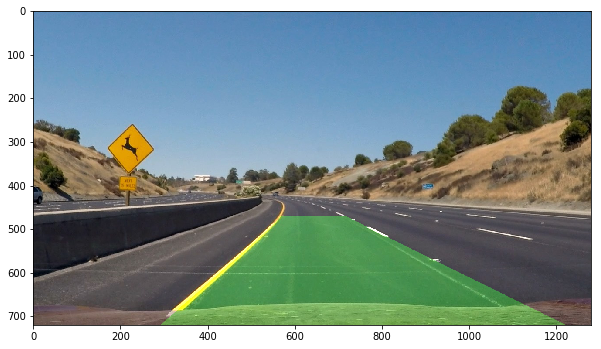

In [16]:
# Cell 16
out_img = np.dstack((warped, warped, warped))*255
y_points = np.linspace(0, num_rows-1, num_rows)
left_line_window = np.array(np.transpose(np.vstack([leftx_predictions, y_points])))
right_line_window = np.array(np.flipud(np.transpose(np.vstack([rightx_predictions, y_points]))))
line_points = np.vstack((left_line_window, right_line_window))
cv2.fillPoly(out_img, np.int_([line_points]), [0,255, 0])
unwarped = cv2.warpPerspective(out_img, M_inv, img_size , flags=cv2.INTER_LINEAR)
result = cv2.addWeighted(img, 1, unwarped, 0.3, 0)
plt.figure(figsize=(10,7))
plt.imshow(result)

# Step 9: Final Pipeline for Video
_______________________________

1. Complete Pipeline for images.
2. restart_lane_finder() - This function restarts the lane finding from scratch if there are no values in leftx_predictions and rightx_predictions for frames.
3. smoothening_lane() - This function perfomes smoothening of values by averaging over previous 12 frames.

In [18]:
# Cell 17

# Some global variables
polyfit_left=None
polyfit_right=None

old_left_lane_ids = []
old_right_lane_ids = []

mean_space_between_lines = 0

def get_lane_lines_prior(nonzeros_x, nonzeros_y, left_coordinates, right_coordinates, num_rows):
    """
        Generation of Lane Line using previous sliding window nonzero and left and right coordinates.
    """
    leftx = nonzeros_x[left_coordinates]
    lefty = nonzeros_y[left_coordinates]
    
    # If no pixels were found return None
    if(lefty.size == 0 or leftx.size == 0):
        return None, None

    # Fit the polynomial
    polyfit_left = np.polyfit(lefty, leftx, 2)

    right_x = nonzeros_x[right_coordinates]
    right_y = nonzeros_y[right_coordinates]
    
    # If no pixels were found return None
    if(right_y.size == 0 or right_x.size == 0):
        return None, None

    # Fit the polynomial
    polyfit_right = np.polyfit(right_y, right_x, 2)

    # If no pixels were found return None
    y_points = np.linspace(0, num_rows-1, num_rows)
    
    # Generate the lane lines from the polynomial fit
    leftx_predictions = polyfit_left[0]*y_points**2 + polyfit_left[1]*y_points + polyfit_left[2]
    rightx_predictions = polyfit_right[0]*y_points**2 + polyfit_right[1]*y_points + polyfit_right[2]
    
    return leftx_predictions, rightx_predictions

def restart_lane_finder(warped):
    """
        This function searches for lane lines from scratch.
        Thresholding & performing a sliding window search.
    """
    nonzeros = warped.nonzero()
    nonzeros_y = nonzeros[0]
    nonzeros_x = nonzeros[1]
    
    num_rows = warped.shape[0]
    
    histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)

    half_width = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:half_width])
    rightx_base = np.argmax(histogram[half_width:]) + half_width

    num_windows = 9
    window_height = np.int(num_rows/num_windows)
    window_half_width = 50

    min_pixels = 100

    left_coordinates = []
    right_coordinates = []

    for window in range(num_windows):
        y_max = num_rows - window*window_height
        y_min = num_rows - (window+1)* window_height

        leftx_min = leftx_base - window_half_width
        leftx_max = leftx_base + window_half_width

        left_lane_inds = ((nonzeros_x >= leftx_min) & (nonzeros_x <= leftx_max) & (nonzeros_y >= y_min) & (nonzeros_y <= y_max)).nonzero()[0]
        left_coordinates.append(left_lane_inds)

        if len(left_lane_inds) > min_pixels:
            leftx_base = np.int(np.mean(nonzeros_x[left_lane_inds]))

        right_x_min = rightx_base - window_half_width
        right_x_max = rightx_base + window_half_width

        right_lane_inds = ((nonzeros_x >= right_x_min) & (nonzeros_x <= right_x_max) & (nonzeros_y >= y_min) & (nonzeros_y <= y_max)).nonzero()[0]
        right_coordinates.append(right_lane_inds)

        if len(right_lane_inds) > min_pixels:
            rightx_base = np.int(np.mean(nonzeros_x[right_lane_inds]))

    left_coordinates = np.concatenate(left_coordinates)
    right_coordinates = np.concatenate(right_coordinates)
    
    leftx_predictions, rightx_predictions = get_lane_lines_prior(nonzeros_x, nonzeros_y, left_coordinates, right_coordinates, num_rows)
    return leftx_predictions, rightx_predictions

def smoothening_lane(previous_lines, new_line):
    """
        This function perfomes smoothening of values by averaging over previous frames.
    """
    
    # Number of frames to average over
    num_frames = 12
    
    if new_line is None:
        # No line was detected
        
        if len(previous_lines) == 0:
            # If there are no previous lines, return None
            return previous_lines, None
        else:
            return previous_lines, previous_lines[-1]
    else:
        if len(previous_lines) < num_frames:
            previous_lines.append(new_line)
            return previous_lines, new_line
        else:
            previous_lines[0:num_frames-1] = previous_lines[1:]
            previous_lines[num_frames-1] = new_line
            new_line = np.zeros_like(new_line)
            for i in range(num_frames):
                new_line += previous_lines[i]
            new_line /= num_frames
            return previous_lines, new_line     

    

def frame_pipeline(img):
    # global variables to store the polynomial coefficients of the line detected in the last frame
    global polyfit_left
    global polyfit_right
    global old_left_lane_ids
    global old_right_lane_ids
    global mean_space_between_lines
    # global variables to store the line coordinates in previous n (=4) frames
    
    
    # global variable which contains running average of the mean difference between left and right lanes   
    
    img_shape = img.shape
    img_size = (image_shape[1], image_shape[0])
    
    # get thresholded image
    thresholded = thresholded_image(img)
    
    # perform a perspective transform
    bottom_left_src = [220,720]
    bottom_right_src = [1110, 720]
    top_left_src = [570, 470]
    top_right_src = [722, 470]

    bottom_left_dst = [320,720]
    bottom_right_dst = [920, 720]
    top_left_dst = [320, 1]
    top_right_dst = [920, 1]
    
    img_size = (image_shape[1], image_shape[0])
    warped, M, M_inv = perspective_transform(thresholded, bottom_left_src, bottom_right_src, top_left_src, top_right_src,
                                             bottom_left_dst, bottom_right_dst, top_left_dst, top_right_dst, img_size)
    
    out_img = np.dstack((warped, warped, warped))*255
    
    nonzeros = warped.nonzero()
    nonzeros_y = nonzeros[0]
    nonzeros_x = nonzeros[1]
    
    num_rows = warped.shape[0]
    y_points = np.linspace(0, num_rows-1, num_rows)
    
    if (polyfit_left is None) or (polyfit_right is None):
        # If the polynomial coefficients of the previous frames are None then restart the lane finding process from scratch
        scratch = True
        leftx_predictions, rightx_predictions = restart_lane_finder(warped)
    else:
        # Else search in a margin of 75 pixels on each side of the pervious polynomial fit
        scratch = False
        margin = 100
        leftx_predictions = polyfit_left[0]*nonzeros_y**2 + polyfit_left[1]*nonzeros_y + polyfit_left[2]
        left_coordinates = ((nonzeros_x >= leftx_predictions - margin) & (nonzeros_x <= leftx_predictions + margin)).nonzero()[0]

        rightx_predictions = polyfit_right[0]*nonzeros_y**2 + polyfit_right[1]*nonzeros_y + polyfit_right[2]
        right_coordinates = ((nonzeros_x >= rightx_predictions - margin) & (nonzeros_x <= rightx_predictions + margin)).nonzero()[0]
        
        leftx_predictions, rightx_predictions = get_lane_lines_prior(nonzeros_x, nonzeros_y, left_coordinates, right_coordinates, num_rows)
    
    if (leftx_predictions is None or rightx_predictions is None):
        if not scratch:
            leftx_predictions, rightx_predictions = restart_lane_finder(warped)
            
    bad_lines = False
            
    if (leftx_predictions is None or rightx_predictions is None):
        bad_lines = True
    else:
        mean_difference = np.mean(rightx_predictions - leftx_predictions)
        
        if mean_space_between_lines == 0:
            mean_space_between_lines = mean_difference
        
        if (mean_difference < 0.7*mean_space_between_lines or mean_difference > 1.3*mean_space_between_lines):
            bad_lines = True
            if not scratch:
                leftx_predictions, rightx_predictions = restart_lane_finder(warped)
                if (leftx_predictions is None or rightx_predictions is None):
                    bad_lines = True
                else:
                    mean_difference = np.mean(rightx_predictions - leftx_predictions)
                    if (mean_difference < 0.7*mean_space_between_lines or mean_difference > 1.3*mean_space_between_lines):
                        bad_lines = True
                    else:
                        bad_lines = False
        else:
            bad_lines = False
            
    if bad_lines:
        polyfit_left = None
        polyfit_right = None
        if len(old_left_lane_ids) == 0 and len(old_right_lane_ids) == 0:
            return img
        else:
            leftx_predictions = old_left_lane_ids[-1]
            rightx_predictions = old_right_lane_ids[-1]
    else:
        old_left_lane_ids, leftx_predictions = smoothening_lane(old_left_lane_ids, leftx_predictions)
        old_right_lane_ids, rightx_predictions = smoothening_lane(old_right_lane_ids, rightx_predictions)
        mean_difference = np.mean(rightx_predictions - leftx_predictions)
        mean_space_between_lines = 0.9*mean_space_between_lines + 0.1*mean_difference
    
    left_line_window = np.array(np.transpose(np.vstack([leftx_predictions, y_points])))
    right_line_window = np.array(np.flipud(np.transpose(np.vstack([rightx_predictions, y_points]))))
    
    # compute the radius of curvature
    left_curve_rad = radius_of_curvature(leftx_predictions)
    right_curve_rad = radius_of_curvature(rightx_predictions)
    average_curve_rad = (left_curve_rad + right_curve_rad)/2
    curvature_string = "Radius of Curvature of Lane Found: %.2f m" % average_curve_rad
    
    # compute the offset from the center
    lane_center = (rightx_predictions[num_rows-1] + leftx_predictions[num_rows-1])/2
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    center_offset_pixels = abs(img_size[0]/2 - lane_center)
    center_offset_mtrs = xm_per_pix*center_offset_pixels
    offset_string = "Position of Car from Centre: %.2f m" % center_offset_mtrs
    
    poly_points = np.vstack([left_line_window, right_line_window])
    
    cv2.fillPoly(out_img, np.int_([poly_points]), [0,255, 0])
    
    unwarped, _, _ = perspective_transform(out_img, bottom_left_src, bottom_right_src, top_left_src, top_right_src,
                                             bottom_left_dst, bottom_right_dst, top_left_dst, top_right_dst, img_size, True)

    result = cv2.addWeighted(img, 1, unwarped, 0.3, 0)
    
    cv2.putText(result, curvature_string , (25, 50), cv2.FONT_HERSHEY_COMPLEX_SMALL     , 1.5, (255,255,255), thickness=2)
    cv2.putText(result, offset_string, (25, 100), cv2.FONT_HERSHEY_COMPLEX_SMALL     , 1.5, (255,255,255), thickness=2)
    
    return result

# Step 10: Testing Final Video Pipeline on Test Images

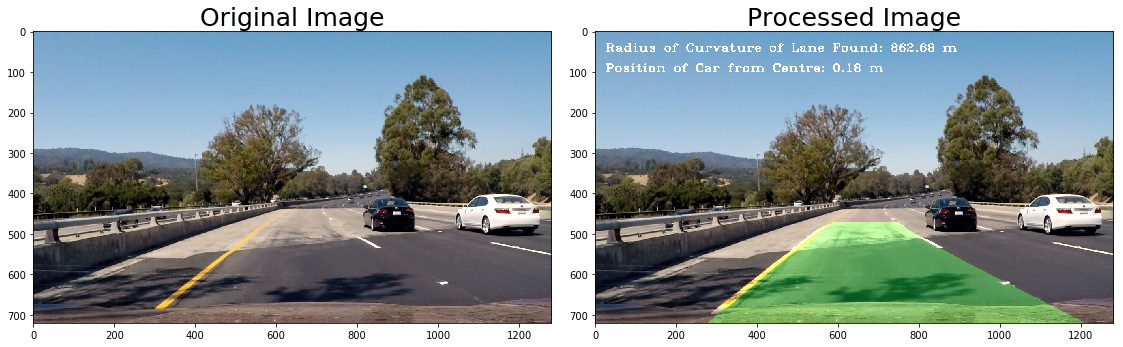

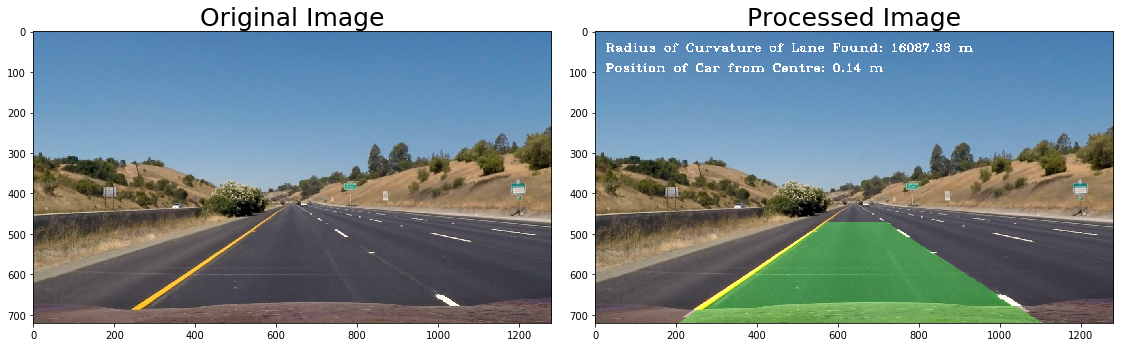

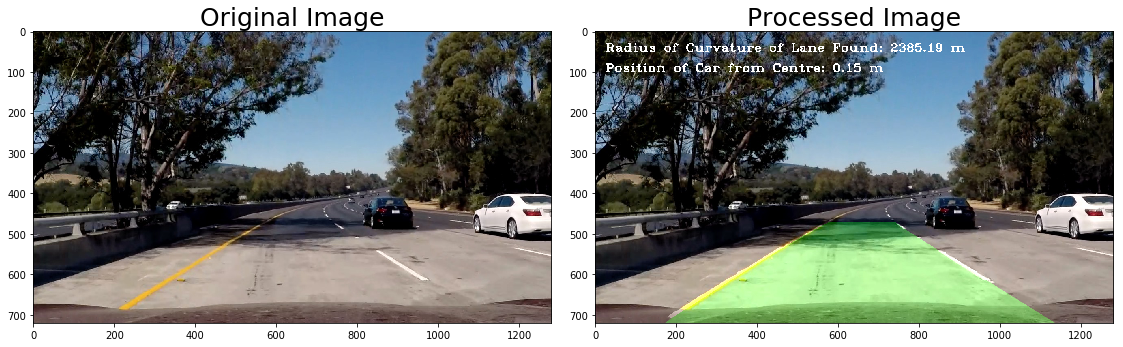

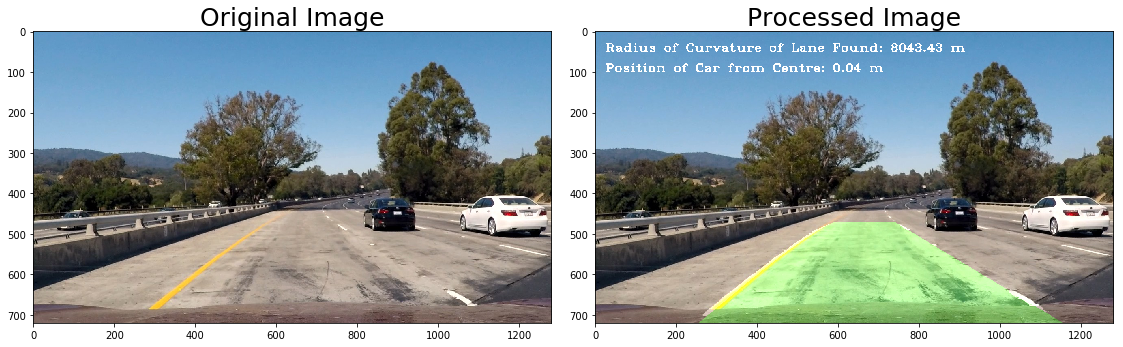

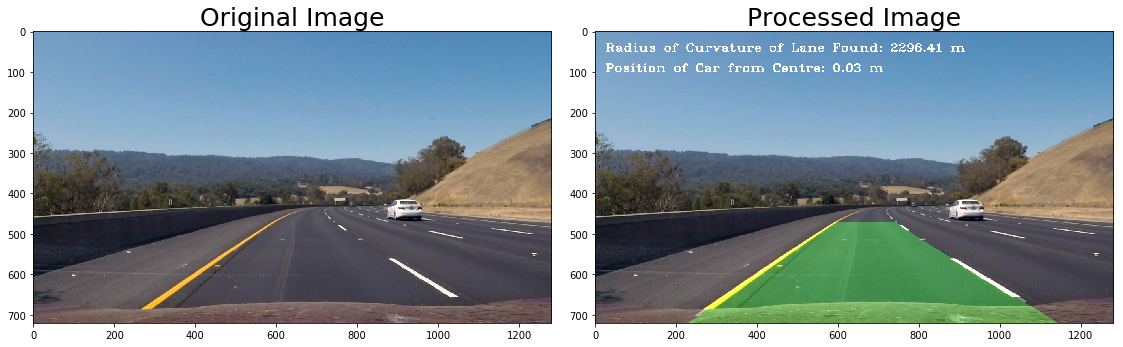

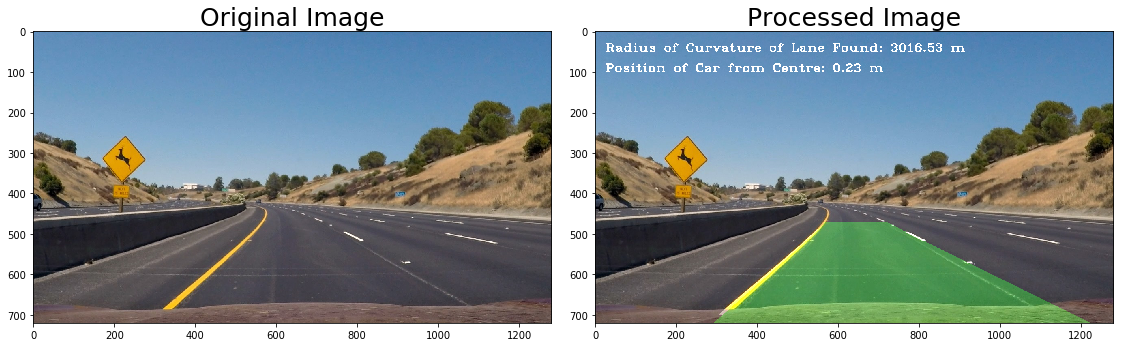

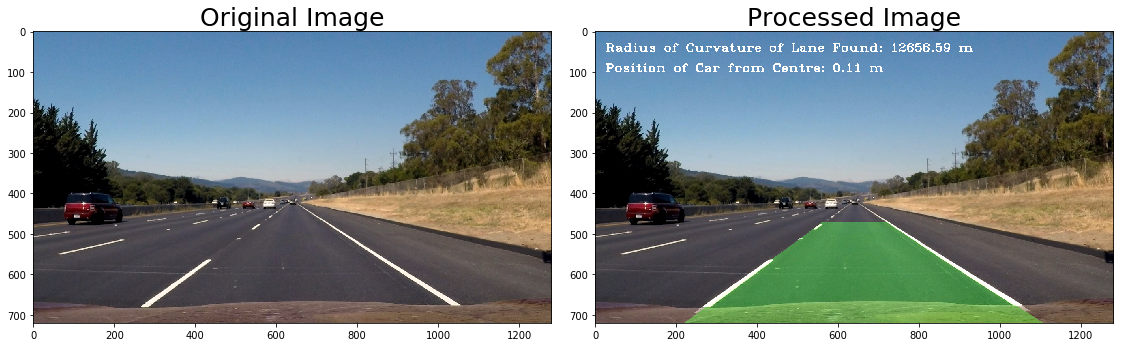

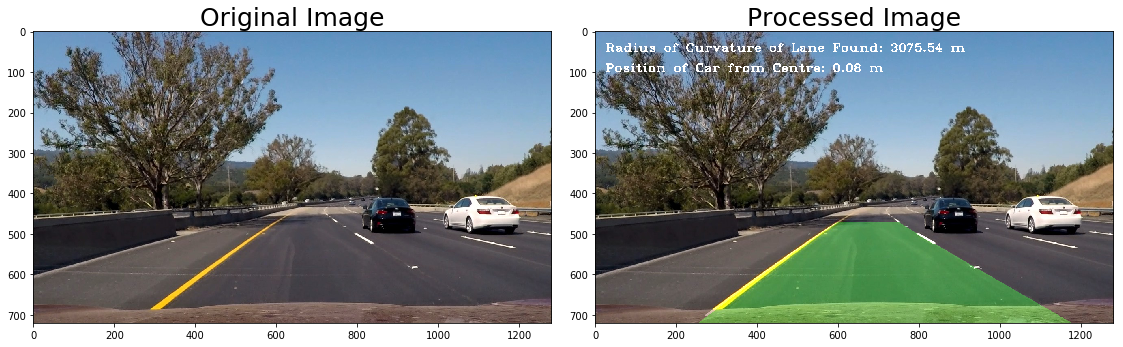

In [19]:
# Cell 18
test_images = glob.glob('test_images/*')

for images in test_images:
    img = mpimg.imread(images)

    # Reinitialize some global variables.
    polyfit_left = None
    polyfit_right = None
    past_good_right_lines = []
    past_good_left_lines = []
    mean_space_between_lines = 0

    # Apply pipeline
    processed = frame_pipeline(img)

    # Plot the 2 images
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=25)
    ax2.imshow(processed, cmap='gray')
    ax2.set_title('Processed Image', fontsize=25)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Step 11: Pipeline Testing (Video) - Final

In [20]:
# Cell 19
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [21]:
# Cell 20
# Reinitialize global variables.
polyfit_left = None
polyfit_right = None
old_left_lane_ids = []
old_right_lane_ids = []
mean_space_between_lines = 0


output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(frame_pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [07:34<00:00,  2.73it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 4min 26s, sys: 59.8 s, total: 5min 25s
Wall time: 7min 37s


In [22]:
# Cell 21
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

In [23]:
# Cell 22
# Reinitialize global variables.
polyfit_left = None
polyfit_right = None
old_left_lane_ids = []
old_right_lane_ids = []
mean_space_between_lines = 0


output = 'challenge_video_output.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(frame_pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


100%|██████████| 485/485 [02:52<00:00,  2.86it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

CPU times: user 1min 42s, sys: 22.6 s, total: 2min 5s
Wall time: 2min 55s


In [24]:
# Cell 23
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

## Vertice Changes for Improved Edge Detection in Harder Challenge during non-curved areas

Better than previous video results but still not perfect

In [25]:
# Cell 17

# Some global variables
polyfit_left=None
polyfit_right=None

old_left_lane_ids = []
old_right_lane_ids = []

mean_space_between_lines = 0

def get_lane_lines_prior(nonzeros_x, nonzeros_y, left_coordinates, right_coordinates, num_rows):
    """
        Generation of Lane Line using previous sliding window nonzero and left and right coordinates.
    """
    leftx = nonzeros_x[left_coordinates]
    lefty = nonzeros_y[left_coordinates]
    
    # If no pixels were found return None
    if(lefty.size == 0 or leftx.size == 0):
        return None, None

    # Fit the polynomial
    polyfit_left = np.polyfit(lefty, leftx, 2)

    right_x = nonzeros_x[right_coordinates]
    right_y = nonzeros_y[right_coordinates]
    
    # If no pixels were found return None
    if(right_y.size == 0 or right_x.size == 0):
        return None, None

    # Fit the polynomial
    polyfit_right = np.polyfit(right_y, right_x, 2)

    # If no pixels were found return None
    y_points = np.linspace(0, num_rows-1, num_rows)
    
    # Generate the lane lines from the polynomial fit
    leftx_predictions = polyfit_left[0]*y_points**2 + polyfit_left[1]*y_points + polyfit_left[2]
    rightx_predictions = polyfit_right[0]*y_points**2 + polyfit_right[1]*y_points + polyfit_right[2]
    
    return leftx_predictions, rightx_predictions

def restart_lane_finder(warped):
    """
        This function searches for lane lines from scratch.
        Thresholding & performing a sliding window search.
    """
    nonzeros = warped.nonzero()
    nonzeros_y = nonzeros[0]
    nonzeros_x = nonzeros[1]
    
    num_rows = warped.shape[0]
    
    histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)

    half_width = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:half_width])
    rightx_base = np.argmax(histogram[half_width:]) + half_width

    num_windows = 5
    window_height = np.int(num_rows/num_windows)
    window_half_width = 50

    min_pixels = 50

    left_coordinates = []
    right_coordinates = []

    for window in range(num_windows):
        y_max = num_rows - window*window_height
        y_min = num_rows - (window+1)* window_height

        leftx_min = leftx_base - window_half_width
        leftx_max = leftx_base + window_half_width

        left_lane_inds = ((nonzeros_x >= leftx_min) & (nonzeros_x <= leftx_max) & (nonzeros_y >= y_min) & (nonzeros_y <= y_max)).nonzero()[0]
        left_coordinates.append(left_lane_inds)

        if len(left_lane_inds) > min_pixels:
            leftx_base = np.int(np.mean(nonzeros_x[left_lane_inds]))

        right_x_min = rightx_base - window_half_width
        right_x_max = rightx_base + window_half_width

        right_lane_inds = ((nonzeros_x >= right_x_min) & (nonzeros_x <= right_x_max) & (nonzeros_y >= y_min) & (nonzeros_y <= y_max)).nonzero()[0]
        right_coordinates.append(right_lane_inds)

        if len(right_lane_inds) > min_pixels:
            rightx_base = np.int(np.mean(nonzeros_x[right_lane_inds]))

    left_coordinates = np.concatenate(left_coordinates)
    right_coordinates = np.concatenate(right_coordinates)
    
    leftx_predictions, rightx_predictions = get_lane_lines_prior(nonzeros_x, nonzeros_y, left_coordinates, right_coordinates, num_rows)
    return leftx_predictions, rightx_predictions

def smoothening_lane(previous_lines, new_line):
    """
        This function perfomes smoothening of values by averaging over previous frames.
    """
    
    # Number of frames to average over
    num_frames = 7
    
    if new_line is None:
        # No line was detected
        
        if len(previous_lines) == 0:
            # If there are no previous lines, return None
            return previous_lines, None
        else:
            return previous_lines, previous_lines[-1]
    else:
        if len(previous_lines) < num_frames:
            previous_lines.append(new_line)
            return previous_lines, new_line
        else:
            previous_lines[0:num_frames-1] = previous_lines[1:]
            previous_lines[num_frames-1] = new_line
            new_line = np.zeros_like(new_line)
            for i in range(num_frames):
                new_line += previous_lines[i]
            new_line /= num_frames
            return previous_lines, new_line     

    

def frame_pipeline(img):
    # global variables to store the polynomial coefficients of the line detected in the last frame
    global polyfit_left
    global polyfit_right
    global old_left_lane_ids
    global old_right_lane_ids
    global mean_space_between_lines
    global leftx_predictions
    global rightx_predictions
    # global variables to store the line coordinates in previous n (=4) frames
    
    
    # global variable which contains running average of the mean difference between left and right lanes   
    
    img_shape = img.shape
    img_size = (image_shape[1], image_shape[0])
    
    # get thresholded image
    thresholded = thresholded_image(img)

    radius_filter = (radius_of_curvature(leftx_predictions) + radius_of_curvature(rightx_predictions))/2
    #print(radius_filter)#, leftx_predictions, rightx_predictions)
    #radius_filter = 2000
    # perform a perspective transform   

    
    if radius_filter > 1500:
        bottom_left_src = [410, 560]
        bottom_right_src = [850, 560]
        top_left_src = [1110, 720]
        top_right_src = [200, 720]

        bottom_left_dst = [320, 0]
        bottom_right_dst = [960, 0]
        top_left_dst = [960, 720]
        top_right_dst = [320, 720]
        
    elif radius_filter <= 1500:
        bottom_left_src = [480, 500]
        bottom_right_src = [740, 500]
        top_left_src = [1110, 720]
        top_right_src = [200, 720]

        bottom_left_dst = [320, 0]
        bottom_right_dst = [960, 0]
        top_left_dst = [960, 720]
        top_right_dst = [320, 720]
    
    img_size = (image_shape[1], image_shape[0])
    warped, M, M_inv = perspective_transform(thresholded, bottom_left_src, bottom_right_src, top_left_src, top_right_src,
                                             bottom_left_dst, bottom_right_dst, top_left_dst, top_right_dst, img_size)
    
    out_img = np.dstack((warped, warped, warped))*255
    
    nonzeros = warped.nonzero()
    nonzeros_y = nonzeros[0]
    nonzeros_x = nonzeros[1]
    
    num_rows = warped.shape[0]
    y_points = np.linspace(0, num_rows-1, num_rows)
    
    if (polyfit_left is None) or (polyfit_right is None):
        # If the polynomial coefficients of the previous frames are None then restart the lane finding process from scratch
        scratch = True
        leftx_predictions, rightx_predictions = restart_lane_finder(warped)
    else:
        # Else search in a margin of 75 pixels on each side of the pervious polynomial fit
        scratch = False
        margin = 100
        leftx_predictions = polyfit_left[0]*nonzeros_y**2 + polyfit_left[1]*nonzeros_y + polyfit_left[2]
        left_coordinates = ((nonzeros_x >= leftx_predictions - margin) & (nonzeros_x <= leftx_predictions + margin)).nonzero()[0]

        rightx_predictions = polyfit_right[0]*nonzeros_y**2 + polyfit_right[1]*nonzeros_y + polyfit_right[2]
        right_coordinates = ((nonzeros_x >= rightx_predictions - margin) & (nonzeros_x <= rightx_predictions + margin)).nonzero()[0]
        
        leftx_predictions, rightx_predictions = get_lane_lines_prior(nonzeros_x, nonzeros_y, left_coordinates, right_coordinates, num_rows)
    
    if (leftx_predictions is None or rightx_predictions is None):
        if not scratch:
            leftx_predictions, rightx_predictions = restart_lane_finder(warped)
            
    bad_lines = False
            
    if (leftx_predictions is None or rightx_predictions is None):
        bad_lines = True
    else:
        mean_difference = np.mean(rightx_predictions - leftx_predictions)
        
        if mean_space_between_lines == 0:
            mean_space_between_lines = mean_difference
        
        if (mean_difference < 0.7*mean_space_between_lines or mean_difference > 1.3*mean_space_between_lines):
            bad_lines = True
            if not scratch:
                leftx_predictions, rightx_predictions = restart_lane_finder(warped)
                if (leftx_predictions is None or rightx_predictions is None):
                    bad_lines = True
                else:
                    mean_difference = np.mean(rightx_predictions - leftx_predictions)
                    if (mean_difference < 0.7*mean_space_between_lines or mean_difference > 1.3*mean_space_between_lines):
                        bad_lines = True
                    else:
                        bad_lines = False
        else:
            bad_lines = False
            
    if bad_lines:
        polyfit_left = None
        polyfit_right = None
        if len(old_left_lane_ids) == 0 and len(old_right_lane_ids) == 0:
            return img
        else:
            leftx_predictions = old_left_lane_ids[-1]
            rightx_predictions = old_right_lane_ids[-1]
    else:
        old_left_lane_ids, leftx_predictions = smoothening_lane(old_left_lane_ids, leftx_predictions)
        old_right_lane_ids, rightx_predictions = smoothening_lane(old_right_lane_ids, rightx_predictions)
        mean_difference = np.mean(rightx_predictions - leftx_predictions)
        mean_space_between_lines = 0.9*mean_space_between_lines + 0.1*mean_difference
    
    left_line_window = np.array(np.transpose(np.vstack([leftx_predictions, y_points])))
    right_line_window = np.array(np.flipud(np.transpose(np.vstack([rightx_predictions, y_points]))))
    
    # compute the radius of curvature
    left_curve_rad = radius_of_curvature(leftx_predictions)
    right_curve_rad = radius_of_curvature(rightx_predictions)
    average_curve_rad = (left_curve_rad + right_curve_rad)/2
    curvature_string = "Radius of Curvature of Lane Found: %.2f m" % average_curve_rad
    
    # compute the offset from the center
    lane_center = (rightx_predictions[num_rows-1] + leftx_predictions[num_rows-1])/2
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    center_offset_pixels = abs(img_size[0]/2 - lane_center)
    center_offset_mtrs = xm_per_pix*center_offset_pixels
    offset_string = "Position of Car from Centre: %.2f m" % center_offset_mtrs
    
    poly_points = np.vstack([left_line_window, right_line_window])
    
    cv2.fillPoly(out_img, np.int_([poly_points]), [0,255, 0])
    
    unwarped, _, _ = perspective_transform(out_img, bottom_left_src, bottom_right_src, top_left_src, top_right_src,
                                             bottom_left_dst, bottom_right_dst, top_left_dst, top_right_dst, img_size, True)

    result = cv2.addWeighted(img, 1, unwarped, 0.3, 0)
    
    cv2.putText(result, curvature_string , (25, 50), cv2.FONT_HERSHEY_COMPLEX_SMALL     , 1.5, (255,255,255), thickness=2)
    cv2.putText(result, offset_string, (25, 100), cv2.FONT_HERSHEY_COMPLEX_SMALL     , 1.5, (255,255,255), thickness=2)
    
    return result

In [26]:
# Cell 24
# Reinitialize global variables.
polyfit_left = None
polyfit_right = None
old_left_lane_ids = []
old_right_lane_ids = []
mean_space_between_lines = 0


output = 'harder_challenge_video_output.mp4'
clip1 = VideoFileClip("harder_challenge_video.mp4")
white_clip = clip1.fl_image(frame_pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video harder_challenge_video_output.mp4
[MoviePy] Writing video harder_challenge_video_output.mp4


100%|█████████▉| 1199/1200 [07:59<00:00,  2.51it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_output.mp4 

CPU times: user 4min 29s, sys: 53.6 s, total: 5min 22s
Wall time: 8min 3s


In [27]:
# Cell 25
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))